In [1]:
# Install the required libraries
!pip install prophet

In [1]:
# Dependencies
# NOTE: We might not use all of these. I just improrted everything I can think of for now. We'll delete the ones we don't need later
import requests
import time
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import json
import path

ModuleNotFoundError: No module named 'path'

In [ ]:
#Read data into the notebook
linkedin_postings_df = pd.read_csv('./data_sets/postings.csv').dropna()
machine_learning_jobs_df = pd.read_json('./data_sets/job_data.json', lines=True)

***Introduction*** 
The goal of this exploratory data analysis is to characterize and investigate the growth of machine learning as a job skill. We are interested in looking at this topic along a number angles. TBC....

QUESTION US Census Predictions

In [2]:
# Additional dependencies
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [3]:
# Additional data reading
combined_acs5 = pd.read_csv('./data_sets/combined_acs5_12-22_data.csv')

In [4]:
# Creating a working DF for population calculations
for row in combined_acs5:
    pop_data = combined_acs5.loc[:,[
                'Name',
                'Year',
                'population',
                'employment_employed',
                'employment_unemployed',
                'education_none',
                'education_high_school',
                'education_ged',
                'education_associates',
                'education_bachelors',
                'education_masters',
                'education_professional',
                'education_doctorate'
                ]]
    pop_data['Percent Employed'] = (combined_acs5.loc[:,'employment_employed']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent Unemployed'] = (combined_acs5.loc[:,'employment_unemployed']/combined_acs5.loc[:,'population']) * 100
    pop_data['Total Pop in Tech Fields'] = (
                                            combined_acs5.loc[:,'employment_male_business_and_financial_operations_occupations'] +
                                            combined_acs5.loc[:,'employment_male_computer_engineering_and_science_occupations'] +
                                            combined_acs5.loc[:,'employment_male_computer_and_mathematical_occupations'] +
                                            combined_acs5.loc[:,'employment_female_business_and_financial_operations_occupations'] +
                                            combined_acs5.loc[:,'employment_female_computer_engineering_and_science_occupations'] +
                                            combined_acs5.loc[:,'employment_female_computer_and_mathematical_occupations']
                                        )
    pop_data['Percent in Tech Fields'] = (pop_data.loc[:,'Total Pop in Tech Fields']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent No Education'] = (combined_acs5.loc[:,'education_none']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent High School'] = (combined_acs5.loc[:,'education_high_school']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent GED'] = (combined_acs5.loc[:,'education_ged']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent Associates'] = (combined_acs5.loc[:,'education_associates']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent Bachelors'] = (combined_acs5.loc[:,'education_bachelors']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent Masters'] = (combined_acs5.loc[:,'education_masters']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent Professional Education'] = (combined_acs5.loc[:,'education_professional']/combined_acs5.loc[:,'population']) * 100
    pop_data['Percent Doctorate'] = (combined_acs5.loc[:,'education_doctorate']/combined_acs5.loc[:,'population']) * 100

# Confirming working DF populated correctly
display(pop_data.head(3))
display(pop_data.tail(3))

,Name,Year,population,employment_employed,employment_unemployed,education_none,education_high_school,education_ged,education_associates,education_bachelors,...,Total Pop in Tech Fields,Percent in Tech Fields,Percent No Education,Percent High School,Percent GED,Percent Associates,Percent Bachelors,Percent Masters,Percent Professional Education,Percent Doctorate
0,Alabama,2012,4777326.0,2017887.0,230778.0,40659.0,818162.0,173244.0,227301.0,448117.0,...,200378.0,4.194355,0.851083,17.125940,3.626380,4.757913,9.380080,3.829757,0.934874,0.612518
1,Alaska,2012,711139.0,341115.0,31369.0,2674.0,98765.0,22507.0,35312.0,79441.0,...,37544.0,5.279418,0.376017,13.888283,3.164923,4.965555,11.170953,4.318143,1.054224,0.748377
2,Arizona,2012,6410979.0,2733537.0,296132.0,51467.0,847998.0,164505.0,339398.0,702007.0,...,351122.0,5.476886,0.802795,13.227278,2.565989,5.294012,10.950075,4.498751,1.075405,0.713432


,Name,Year,population,employment_employed,employment_unemployed,education_none,education_high_school,education_ged,education_associates,education_bachelors,...,Total Pop in Tech Fields,Percent in Tech Fields,Percent No Education,Percent High School,Percent GED,Percent Associates,Percent Bachelors,Percent Masters,Percent Professional Education,Percent Doctorate
569,Wisconsin,2022,5882128.0,3020890.0,105086.0,38573.0,1071376.0,139878.0,451044.0,852632.0,...,447403.0,7.606142,0.655766,18.214089,2.378017,7.668041,14.495298,5.430331,1.199481,0.912374
570,Wyoming,2022,577929.0,287895.0,11456.0,2890.0,88797.0,21480.0,46082.0,71313.0,...,27321.0,4.727397,0.500061,15.364690,3.716720,7.973644,12.339405,5.373151,1.051513,0.889037
571,Puerto Rico,2022,3272382.0,1081330.0,165697.0,51914.0,617845.0,54436.0,271432.0,482139.0,...,105007.0,3.208886,1.586428,18.880589,1.663498,8.294631,14.733579,4.115443,0.939621,0.943991


In [5]:
# Converting `Year` to Datetime format for future use with Prophet
# (`YYYY-12-30 11:59:59` chosen for Datetime format since data only came with `YYYY`)
pop_data['Year'] = pd.to_datetime({'year': pop_data['Year'],
                                   'month': 12,
                                   'day': 30,
                                   'hour': 11,
                                   'minute': 59,
                                   'second': 59
                                    })

# Verifying applied correctly
# Confirming working DF populated correctly
display(pop_data.head(3))
display(pop_data.tail(3))

,Name,Year,population,employment_employed,employment_unemployed,education_none,education_high_school,education_ged,education_associates,education_bachelors,...,Total Pop in Tech Fields,Percent in Tech Fields,Percent No Education,Percent High School,Percent GED,Percent Associates,Percent Bachelors,Percent Masters,Percent Professional Education,Percent Doctorate
0,Alabama,2012-12-30 11:59:59,4777326.0,2017887.0,230778.0,40659.0,818162.0,173244.0,227301.0,448117.0,...,200378.0,4.194355,0.851083,17.125940,3.626380,4.757913,9.380080,3.829757,0.934874,0.612518
1,Alaska,2012-12-30 11:59:59,711139.0,341115.0,31369.0,2674.0,98765.0,22507.0,35312.0,79441.0,...,37544.0,5.279418,0.376017,13.888283,3.164923,4.965555,11.170953,4.318143,1.054224,0.748377
2,Arizona,2012-12-30 11:59:59,6410979.0,2733537.0,296132.0,51467.0,847998.0,164505.0,339398.0,702007.0,...,351122.0,5.476886,0.802795,13.227278,2.565989,5.294012,10.950075,4.498751,1.075405,0.713432


,Name,Year,population,employment_employed,employment_unemployed,education_none,education_high_school,education_ged,education_associates,education_bachelors,...,Total Pop in Tech Fields,Percent in Tech Fields,Percent No Education,Percent High School,Percent GED,Percent Associates,Percent Bachelors,Percent Masters,Percent Professional Education,Percent Doctorate
569,Wisconsin,2022-12-30 11:59:59,5882128.0,3020890.0,105086.0,38573.0,1071376.0,139878.0,451044.0,852632.0,...,447403.0,7.606142,0.655766,18.214089,2.378017,7.668041,14.495298,5.430331,1.199481,0.912374
570,Wyoming,2022-12-30 11:59:59,577929.0,287895.0,11456.0,2890.0,88797.0,21480.0,46082.0,71313.0,...,27321.0,4.727397,0.500061,15.364690,3.716720,7.973644,12.339405,5.373151,1.051513,0.889037
571,Puerto Rico,2022-12-30 11:59:59,3272382.0,1081330.0,165697.0,51914.0,617845.0,54436.0,271432.0,482139.0,...,105007.0,3.208886,1.586428,18.880589,1.663498,8.294631,14.733579,4.115443,0.939621,0.943991


In [10]:
# Confirming unique States
pop_data['Name'].value_counts()

Name
Alabama                 11
Alaska                  11
Nevada                  11
New Hampshire           11
New Jersey              11
New Mexico              11
New York                11
North Carolina          11
North Dakota            11
Ohio                    11
Oklahoma                11
Oregon                  11
Pennsylvania            11
Rhode Island            11
South Carolina          11
South Dakota            11
Tennessee               11
Texas                   11
Vermont                 11
Utah                    11
Virginia                11
Washington              11
West Virginia           11
Wisconsin               11
Wyoming                 11
Nebraska                11
Montana                 11
Missouri                11
Hawaii                  11
Arizona                 11
Arkansas                11
California              11
Colorado                11
Delaware                11
District of Columbia    11
Connecticut             11
Florida                

In [9]:
# Confirming data types for `pop_data`
pop_data.dtypes

Name                                      object
Year                              datetime64[ns]
population                               float64
employment_employed                      float64
employment_unemployed                    float64
education_none                           float64
education_high_school                    float64
education_ged                            float64
education_associates                     float64
education_bachelors                      float64
education_masters                        float64
education_professional                   float64
education_doctorate                      float64
Percent Employed                         float64
Percent Unemployed                       float64
Total Pop in Tech Fields                 float64
Percent in Tech Fields                   float64
Percent No Education                     float64
Percent High School                      float64
Percent GED                              float64
Percent Associates  

In [53]:
# Slicing data into working DFs for future use with Prophet
# For total population
slice_pop = pop_data.loc[:,[
                        'Name',
                        'Year',
                        'population'
                        ]]

# For total employed population
slice_emp_tot = pop_data.loc[:,[
                            'Name',
                            'Year',
                            'employment_employed'
                            ]]

# For percentage of employed population
slice_emp_pct = pop_data.loc[:,[
                            'Name',
                            'Year',
                            'Percent Employed'
                            ]]

# For total unemployed population
slice_unemp_tot = pop_data.loc[:,[
                            'Name',
                            'Year',
                            'employment_unemployed'
                            ]]

# For percentage of unemployed population
slice_unemp_pct = pop_data.loc[:,[
                            'Name',
                            'Year',
                            'Percent Unemployed'
                            ]]

# For total with no education
slice_edu_non_tot = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'education_none'
                                ]]

# For percentage with no education
slice_edu_non_pct = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'Percent No Education'
                                ]]

# For total with high school diploma
slice_edu_hs_tot = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'education_high_school'
                                ]]

# For percentage with high school diploma
slice_edu_hs_pct = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'Percent High School'
                                ]]

# For total with GED
slice_edu_ged_tot = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'education_ged'
                                ]]

# For percentage with GED
slice_edu_ged_pct = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'Percent GED'
                                ]]

# For total with associates degree
slice_edu_asc_tot = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'education_associates'
                                ]]

# For percentage with associates degree
slice_edu_asc_pct = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'Percent Associates'
                                ]]

# For total with bachelors degree
slice_edu_bch_tot = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'education_bachelors'
                                ]]

# For percentage with bachelors degree
slice_edu_bch_pct = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'Percent Bachelors'
                                ]]

# For total with masters degree
slice_edu_mst_tot = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'education_masters'
                                ]]

# For percentage with masters degree
slice_edu_mst_pct = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'Percent Masters'
                                ]]

# For total with professional education
slice_edu_prf_tot = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'education_professional'
                                ]]

# For percentage with professional education 
slice_edu_prf_pct = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'Percent Professional Education'
                                ]]

# For total with doctorate
slice_edu_doc_tot = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'education_doctorate'
                                ]]

# For percentage with doctorate 
slice_edu_doc_pct = pop_data.loc[:,[
                                'Name',
                                'Year',
                                'Percent Doctorate'
                                ]]

# For total working in tech-related fields
slice_tech_tot = pop_data.loc[:,[
                            'Name',
                            'Year',
                            'Total Pop in Tech Fields'
                            ]]

# For percentage working in tech-related fields
slice_tech_pct = pop_data.loc[:,[
                            'Name',
                            'Year',
                            'Percent in Tech Fields'
                            ]]

# Below

Testing Prophet functions, nothing committed as of yet.

In [60]:
test_slice = slice_tech_pct[['Year', 'Percent in Tech Fields']]\
            .loc[slice_tech_pct['Name'] == 'Washington']
            
            
test_slice.rename(columns={
                'Year': 'ds',
                'Percent in Tech Fields': 'y'
                }, inplace=True)

test_slice.head(11)

,ds,y
47,2012-12-30 11:59:59,7.559113
99,2013-12-30 11:59:59,7.625016
151,2014-12-30 11:59:59,7.726895
179,2015-12-30 11:59:59,7.866793
231,2016-12-30 11:59:59,8.098334
288,2017-12-30 11:59:59,8.423093
335,2018-12-30 11:59:59,9.080429
411,2019-12-30 11:59:59,9.501159
451,2020-12-30 11:59:59,9.892931
515,2021-12-30 11:59:59,10.240288


In [61]:
m = Prophet()
m

In [62]:
m.fit(test_slice)

19:53:43 - cmdstanpy - INFO - Chain [1] start processing


19:53:43 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
test_future = m.make_future_dataframe(periods=20, freq='Y')

c:\Users\joblu\anaconda3\envs\ai_dev\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


In [64]:
test_forecast = m.predict(test_future)

c:\Users\joblu\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\joblu\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


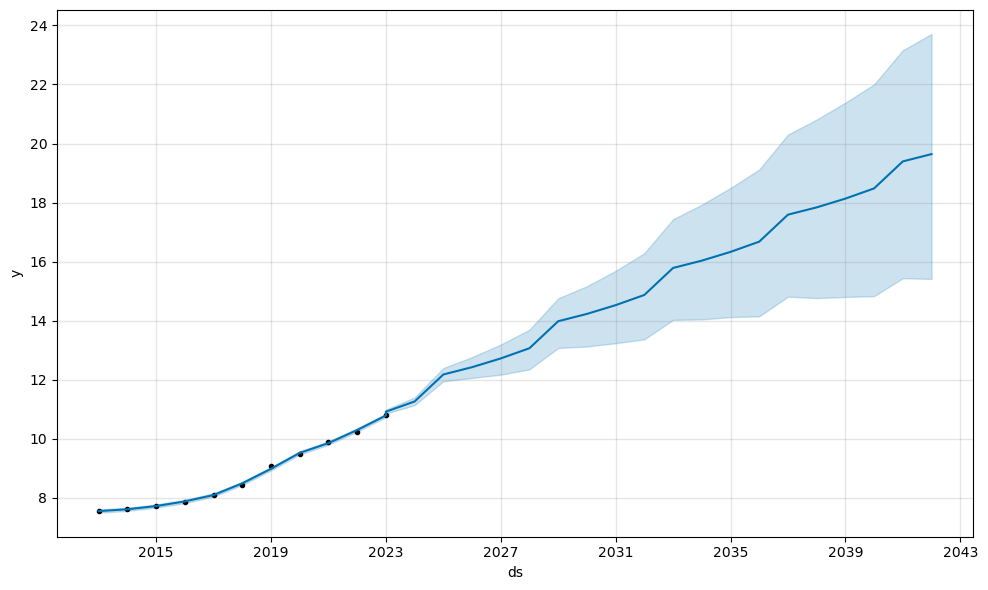

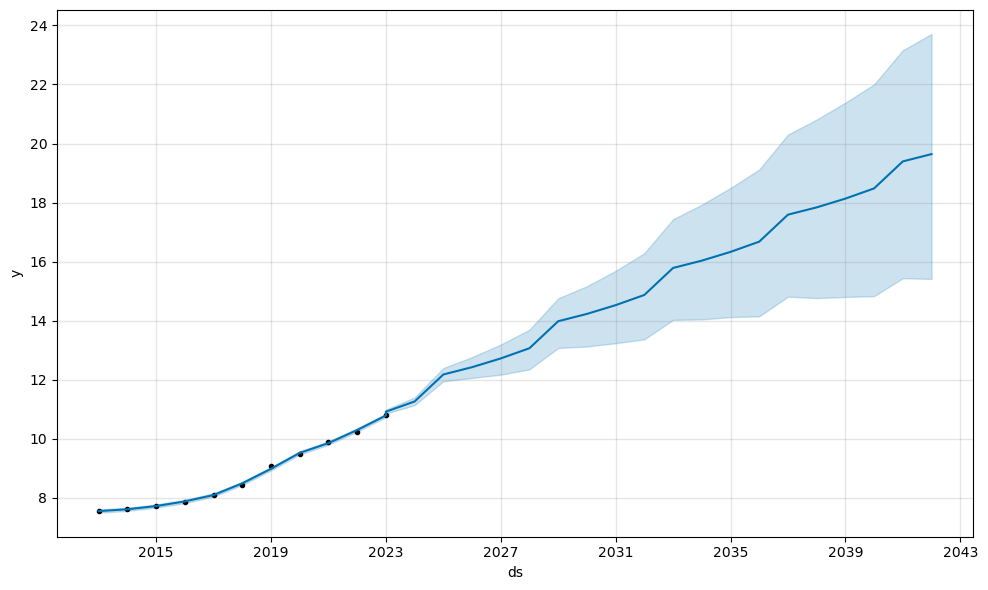

In [65]:
m.plot(test_forecast)

In [66]:
m_unemp = Prophet()
m_unemp

In [67]:
test_unemp = slice_unemp_pct[['Year', 'Percent Unemployed']]\
            .loc[slice_unemp_pct['Name'] == 'Washington']
            
            
test_unemp.rename(columns={
                'Year': 'ds',
                'Percent Unemployed': 'y'
                }, inplace=True)

test_unemp.head(11)

,ds,y
47,2012-12-30 11:59:59,4.586172
99,2013-12-30 11:59:59,4.797290
151,2014-12-30 11:59:59,4.478178
179,2015-12-30 11:59:59,3.976915
231,2016-12-30 11:59:59,3.459451
288,2017-12-30 11:59:59,3.051911
335,2018-12-30 11:59:59,2.718959
411,2019-12-30 11:59:59,2.530082
451,2020-12-30 11:59:59,2.509988
515,2021-12-30 11:59:59,2.602725


In [68]:
m_unemp.fit(test_unemp)

20:00:50 - cmdstanpy - INFO - Chain [1] start processing
20:00:50 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
unemp_future = m_unemp.make_future_dataframe(periods=20, freq='YE')

In [70]:
unemp_forecast = m_unemp.predict(unemp_future)

c:\Users\joblu\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\joblu\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


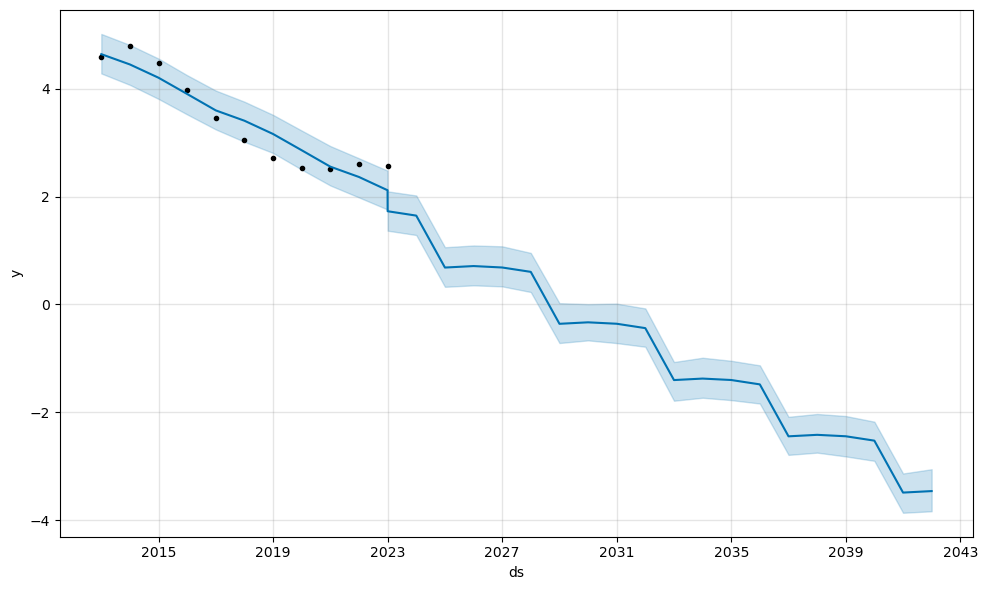

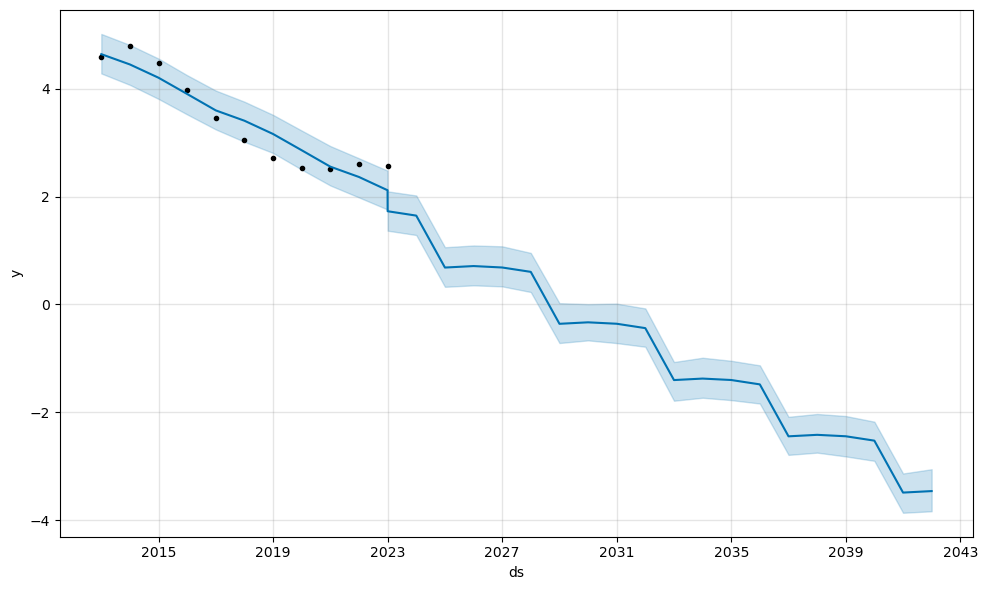

In [71]:
m_unemp.plot(unemp_forecast)

c:\Users\joblu\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\joblu\anaconda3\envs\ai_dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


[]

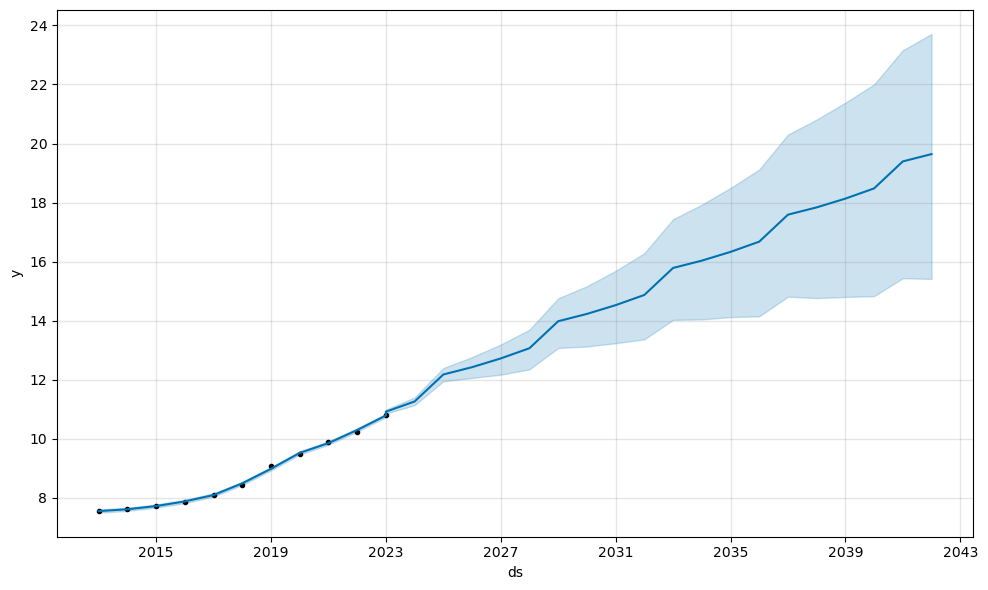

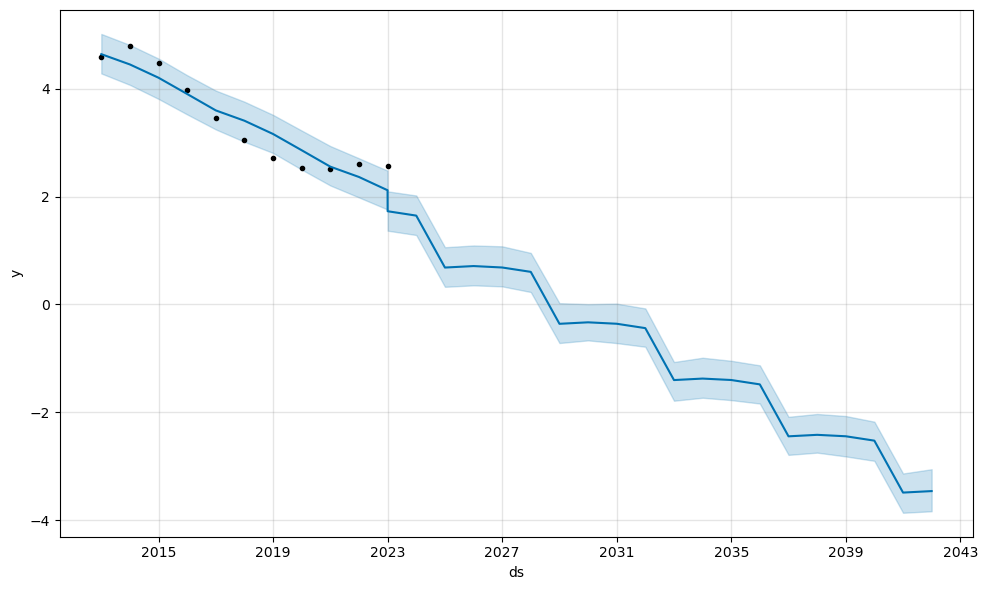

In [74]:
m.plot(test_forecast)
m_unemp.plot(unemp_forecast)

plt.plot()

In [ ]:
# Insert Question 1 analysis and visualizations here. Insert new cells if necessary 

Q1 Summary \[INSERT SUMMARY HERE] ... write a little about what the findings above seem to indicate about question 1

Question 2 Relative proportions ML to not-ML

In [ ]:
# Insert question 2 analysis etc here. Insert new cells if necessary

Q2 Summary \[INSERT SUMMARY HERE]

Question Job Skills

In [ ]:
# etc 

Q3 Summary \[INSERT SUMMARY HERE]

Question Seniority/Job level

In [ ]:
# etc 

Question 5 Industry demand 